#### Getting spacecraft positions


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

import astropy
import sunpy
import astroquery  
from sunpy.coordinates import frames, get_horizons_coord


import heliopy.data.spice as spicedata
import heliopy.spice as spice

import astropy.units as u
import astrospice

/Users/chris/anaconda3/envs/helio3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### sunpy - only works for small array sizes

In [2]:
#Solar Orbiter
coord = get_horizons_coord('Solar Orbiter', time={'start': '2022-09-01', 'stop': '2022-09-30', 'step': '60m'})  
solo_heeq = coord.transform_to(frames.HeliographicStonyhurst) #HEEQ
solo_hee = coord.transform_to(frames.HeliocentricEarthEcliptic)  #HEE

solo_time=solo_heeq.obstime.to_datetime()
solo_r=solo_heeq.radius.value
solo_lon=np.deg2rad(solo_heeq.lon.value)
solo_lat=np.deg2rad(solo_heeq.lat.value)


#PSP
coord = get_horizons_coord('Parker Solar Probe', time={'start': '2022-09-01', 'stop': '2022-09-30', 'step': '60m'})  
psp_heeq=coord.transform_to(frames.HeliographicStonyhurst)

psp_time=psp_heeq.obstime.to_datetime()
psp_r=psp_heeq.radius.value
psp_lon=np.deg2rad(psp_heeq.lon.value)
psp_lat=np.deg2rad(psp_heeq.lat.value)

    

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]


697


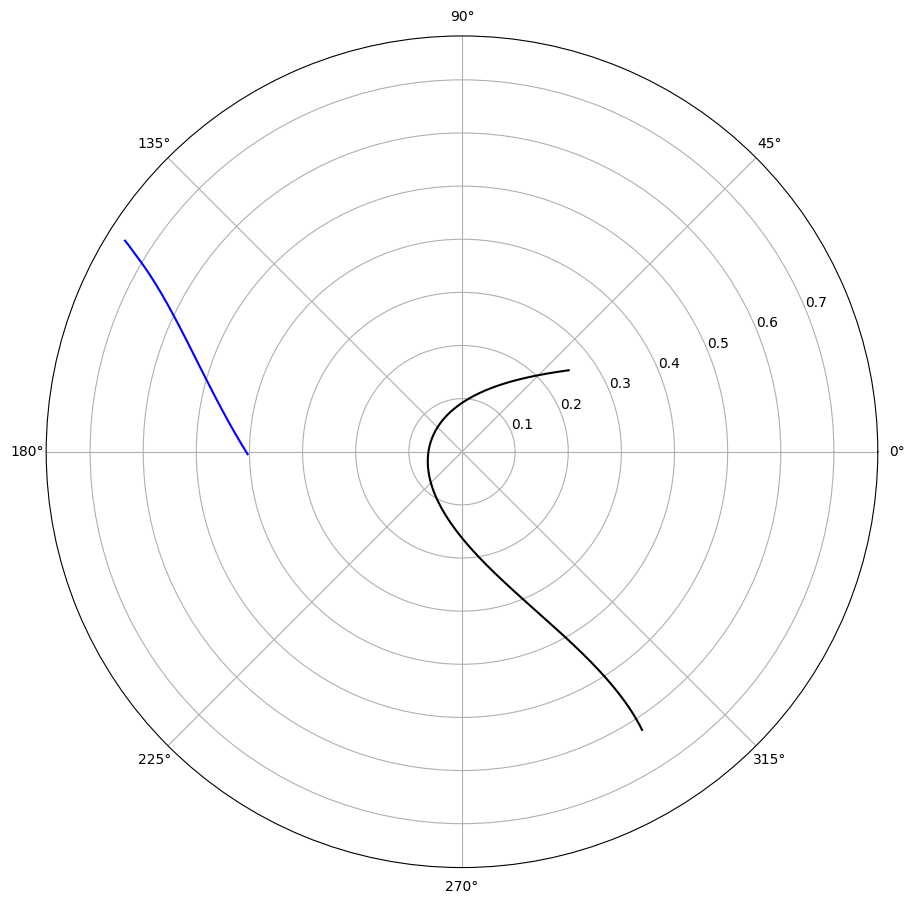

In [3]:
%matplotlib inline

fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax = plt.subplot2grid((1,1), (0, 0), rowspan=7, projection='polar')

plt.plot(solo_lon,solo_r,'b')
plt.plot(psp_lon,psp_r,'k')

print(np.size(solo_lon))



## for larger arrays

### heliopy

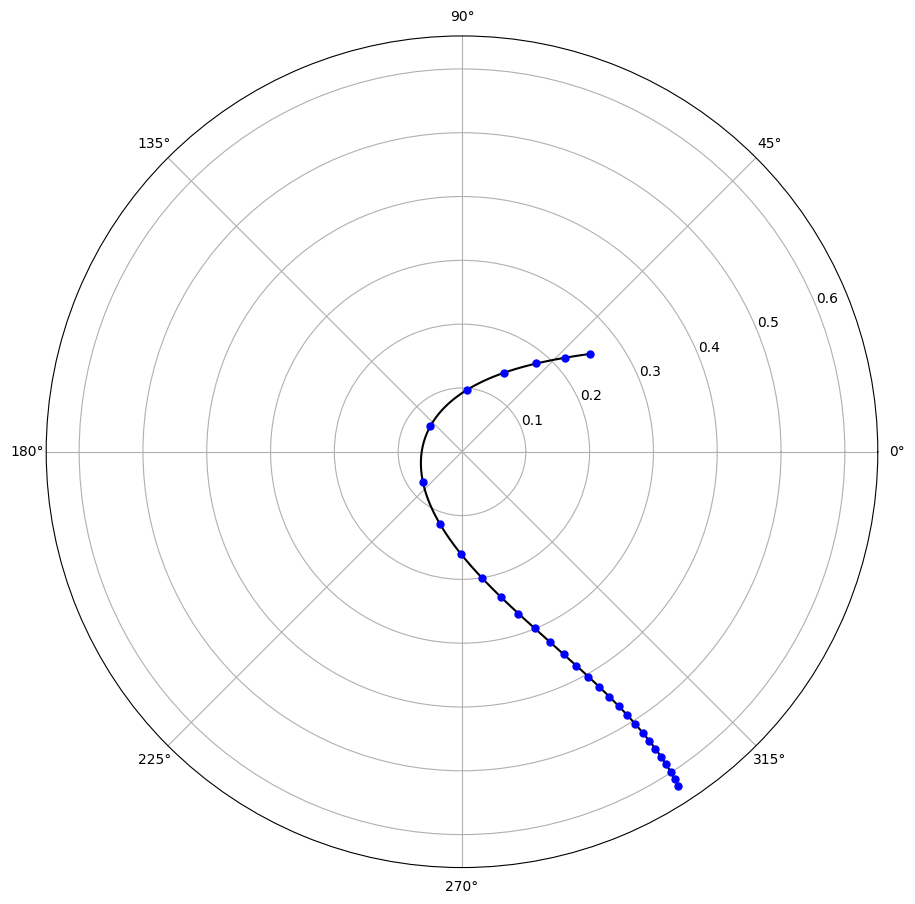

In [4]:
#heliopy - not for Solar Orbiter because this uses an old kernel


def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2)           
    theta = np.arctan2(z,np.sqrt(x**2+ y**2))
    phi = np.arctan2(y,x)                    
    return (r, theta, phi)

starttime = datetime.datetime(2022, 9, 1)
endtime = starttime + timedelta(days=30)
psp_time2 = []
while starttime < endtime:
    psp_time2.append(starttime)
    starttime += timedelta(hours=24) 

spice.furnish(spicedata.get_kernel('psp_pred'))
psp2=spice.Trajectory('SPP')
psp2.generate_positions(psp_time2, 'Sun','HEEQ')
psp2.change_units(astropy.units.AU)
[psp2_r, psp2_lat, psp2_lon]=cart2sphere(psp2.x,psp2.y,psp2.z)


fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax = plt.subplot2grid((1,1), (0, 0), rowspan=7, projection='polar')

plt.plot(psp_lon,psp_r,'k')
plt.plot(psp2_lon,psp2_r,'ob',markersize=5)

In [5]:
#print(np.nanmean(psp2_r.value[0:100]-psp_r[0:100]))

## astrospice for Solar Orbiter (note: not compatible with HelioSat!)

In [6]:
kernels = astrospice.registry.get_kernels('solar orbiter', 'predict')
solo_kernel = kernels[0]

#res_in_days=1/(24)
res_in_days=3

starttime = datetime.datetime(2022, 9, 1)
endtime = datetime.datetime(2022, 9,30)
solo2_time = []
while starttime < endtime:
        solo2_time.append(starttime)
        starttime += timedelta(days=res_in_days)

solo2_coords = astrospice.generate_coords('Solar Orbiter', solo2_time)
solo2_coords_heeq = solo2_coords.transform_to(sunpy.coordinates.HeliographicStonyhurst())

print(np.size(solo2_coords_heeq))



solo2_lon=solo2_coords_heeq.lon.to(u.rad).value
solo2_r=solo2_coords_heeq.radius.to(u.au).value

/Users/chris/anaconda3/envs/helio3/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
Files Downloaded: 100%|█████████████████████████| 1/1 [00:00<00:00,  3.52file/s]

10


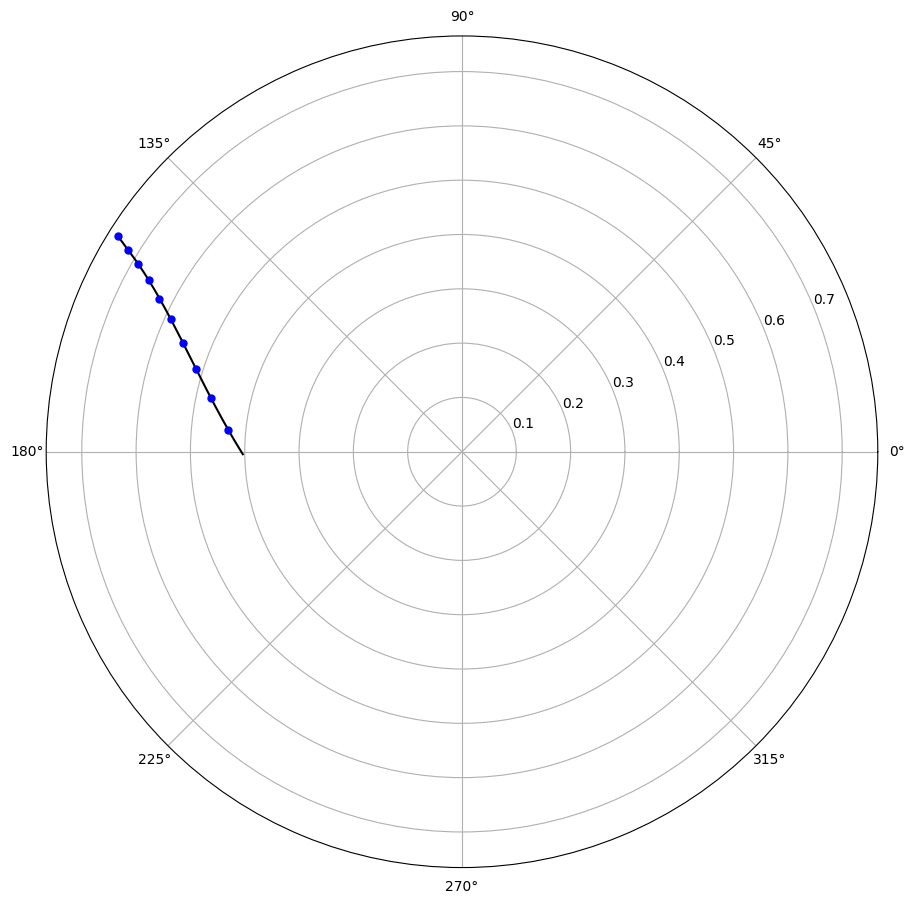

In [7]:

fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax = plt.subplot2grid((1,1), (0, 0), rowspan=7, projection='polar')

plt.plot(solo_lon,solo_r,'k')
plt.plot(solo2_lon, solo2_r, 'ob',markersize=5)

#plt.savefig('../lineups/position_test.pdf')


In [42]:
#solo2_lon[0:100]-solo_lon[0:100]